### Imports


In [1]:
import os
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
import numpy as np
import seaborn as sns
import plotly.express as px
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from uatk_spc.reader import SPCReader
import warnings

warnings.filterwarnings("ignore")

**Notes on the SPC and toolkit**:

- Aims to provide performant exploratory analysis of the data to identify properties
- Clustering among population/regions can be helpful for observing patterns in the data
- Formal statistical analysis should be avoided as the population is synthetic


### 1. Load an example region and explore data structure

As an example, load the SPC output for the Oxford-Cambridge arc region.


In [2]:
path = "../../data/output/special/2020"
region = "oxford_cambridge_arc"

Performant read from parquet and JSON with polars.


In [3]:
spc = SPCReader(path, region, backend="polars")

People dataframe


In [4]:
spc.people.head()

id,household,workplace,location,identifiers,demographics,employment,health,events,weekday_diaries,weekend_diaries
u64,u64,u64,struct[2],struct[4],struct[4],struct[6],struct[7],struct[7],list[u64],list[u64]
0,0,null,"{-0.292946,52.133789}","{""E02003599_0001_001"",11180818,1,2904017}","{2,40,1,6}","{""C"",30,8133,7,null,null}","{37.280968,false,false,false,null,1,3}","{0.255,0.09435,0.016746,0.039074,1.024287,2.390004,0.15741}","[1030, 1260, 5319]","[1031, 1261, 5318]"
1,0,88,"{-0.292946,52.133789}","{""E02003599_0001_002"",14061013,2,2905699}","{1,39,1,1}","{""M"",69,1132,1,127906.320312,70.278198}","{35.771095,false,false,false,null,2,3}","{0.255,0.3213,0.070199,0.030085,2.254896,0.966384,0.15741}","[2832, 7805, … 14038]","[2833, 7804, … 14039]"
2,0,null,"{-0.292946,52.133789}","{""E02003599_0001_003"",16230603,4,2909186}","{2,7,1,null}","{null,null,null,0,null,null}","{null,false,false,false,null,1,null}","{0.257,0.09509,0.013041,0.030429,0.000854,0.001993,0.107325}","[107, 453, … 16247]","[106, 454, … 16246]"
3,1,null,"{-0.292673,52.131351}","{""E02003599_0002_001"",18151205,2,2905565}","{1,66,1,4}","{""O"",84,3313,6,null,null}","{34.354729,true,true,true,4,4,3}","{0.239,0.15057,2.1016e-14,9.0070e-15,0.34922,0.149666,0.15741}","[513, 1819, … 15923]","[514, 1818, … 15924]"
4,1,48941,"{-0.292673,52.131351}","{""E02003599_0002_002"",11090209,1,2902895}","{2,60,1,1}","{""P"",85,1135,1,64961.53125,33.76379}","{20.597435,false,false,false,null,3,null}","{0.268,0.19832,5.6552e-11,1.3196e-10,0.41975,0.979416,0.160325}","[538, 7588, … 14060]","[537, 7589, … 14061]"


In [5]:
spc.summary("people")

Shape: (2950743, 11)


{'id': UInt64,
 'household': UInt64,
 'workplace': UInt64,
 'location': Struct([Field('x', Float32), Field('y', Float32)]),
 'identifiers': Struct([Field('orig_pid', Utf8), Field('id_tus_hh', Int64), Field('id_tus_p', Int64), Field('pid_hs', Int64)]),
 'demographics': Struct([Field('sex', Int32), Field('age_years', UInt32), Field('ethnicity', Int32), Field('nssec8', Int32)]),
 'employment': Struct([Field('sic1d2007', Utf8), Field('sic2d2007', UInt64), Field('soc2010', UInt64), Field('pwkstat', Int32), Field('salary_yearly', Float32), Field('salary_hourly', Float32)]),
 'health': Struct([Field('bmi', Float32), Field('has_cardiovascular_disease', Boolean), Field('has_diabetes', Boolean), Field('has_high_blood_pressure', Boolean), Field('number_medications', UInt64), Field('self_assessed_health', Int32), Field('life_satisfaction', Int32)]),
 'events': Struct([Field('sport', Float32), Field('rugby', Float32), Field('concert_m', Float32), Field('concert_f', Float32), Field('concert_ms', Flo

View unnested forms of: "health", "employment", "events"


In [6]:
col = "health"
print(spc.people.select(col).unnest(col).head())

shape: (5, 7)
┌───────────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ bmi       ┆ has_cardiova ┆ has_diabetes ┆ has_high_blo ┆ number_medi ┆ self_assess ┆ life_satisf │
│ ---       ┆ scular_disea ┆ ---          ┆ od_pressure  ┆ cations     ┆ ed_health   ┆ action      │
│ f32       ┆ se           ┆ bool         ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│           ┆ ---          ┆              ┆ bool         ┆ u64         ┆ i32         ┆ i32         │
│           ┆ bool         ┆              ┆              ┆             ┆             ┆             │
╞═══════════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╡
│ 37.280968 ┆ false        ┆ false        ┆ false        ┆ null        ┆ 1           ┆ 3           │
│ 35.771095 ┆ false        ┆ false        ┆ false        ┆ null        ┆ 2           ┆ 3           │
│ null      ┆ false        ┆ false        ┆ false        ┆ null        ┆ 1   

In [7]:
col = "employment"
print(spc.people.select(col).unnest(col).head())

shape: (5, 6)
┌───────────┬───────────┬─────────┬─────────┬───────────────┬───────────────┐
│ sic1d2007 ┆ sic2d2007 ┆ soc2010 ┆ pwkstat ┆ salary_yearly ┆ salary_hourly │
│ ---       ┆ ---       ┆ ---     ┆ ---     ┆ ---           ┆ ---           │
│ str       ┆ u64       ┆ u64     ┆ i32     ┆ f32           ┆ f32           │
╞═══════════╪═══════════╪═════════╪═════════╪═══════════════╪═══════════════╡
│ C         ┆ 30        ┆ 8133    ┆ 7       ┆ null          ┆ null          │
│ M         ┆ 69        ┆ 1132    ┆ 1       ┆ 127906.320312 ┆ 70.278198     │
│ null      ┆ null      ┆ null    ┆ 0       ┆ null          ┆ null          │
│ O         ┆ 84        ┆ 3313    ┆ 6       ┆ null          ┆ null          │
│ P         ┆ 85        ┆ 1135    ┆ 1       ┆ 64961.53125   ┆ 33.76379      │
└───────────┴───────────┴─────────┴─────────┴───────────────┴───────────────┘


In [8]:
col = "health"
print(spc.people.select(col).unnest(col))

shape: (2_950_743, 7)
┌───────────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┐
│ bmi       ┆ has_cardiova ┆ has_diabetes ┆ has_high_blo ┆ number_medi ┆ self_assess ┆ life_satisf │
│ ---       ┆ scular_disea ┆ ---          ┆ od_pressure  ┆ cations     ┆ ed_health   ┆ action      │
│ f32       ┆ se           ┆ bool         ┆ ---          ┆ ---         ┆ ---         ┆ ---         │
│           ┆ ---          ┆              ┆ bool         ┆ u64         ┆ i32         ┆ i32         │
│           ┆ bool         ┆              ┆              ┆             ┆             ┆             │
╞═══════════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╡
│ 37.280968 ┆ false        ┆ false        ┆ false        ┆ null        ┆ 1           ┆ 3           │
│ 35.771095 ┆ false        ┆ false        ┆ false        ┆ null        ┆ 2           ┆ 3           │
│ null      ┆ false        ┆ false        ┆ false        ┆ null      

Households dataframe


In [9]:
spc.households.head()

id,msoa,oa,members,details
u64,str,str,list[u64],struct[8]
0,"""E02003599""","""E00088035""","[0, 1, 2]","{""E02003599_0001"",6,4,null,5,true,5,2}"
1,"""E02003599""","""E00088045""","[3, 4, 5]","{""E02003599_0002"",4,2,null,6,true,2,2}"
2,"""E02003599""","""E00088033""",[6],"{""E02003599_0003"",8,3,null,2,true,4,1}"
3,"""E02003599""","""E00088052""","[7, 8, 9]","{""E02003599_0004"",5,3,null,5,true,4,0}"
4,"""E02003599""","""E00088040""",[10],"{""E02003599_0005"",6,2,null,6,true,4,0}"


In [10]:
spc.summary("households")

Shape: (1199021, 5)


{'id': UInt64,
 'msoa': Utf8,
 'oa': Utf8,
 'members': List(UInt64),
 'details': Struct([Field('hid', Utf8), Field('nssec8', Int32), Field('accommodation_type', Int32), Field('communal_type', Int32), Field('num_rooms', UInt64), Field('central_heat', Boolean), Field('tenure', Int32), Field('num_cars', UInt64)])}

In [11]:
col = "details"
spc.households.unnest("details").head()

id,msoa,oa,members,hid,nssec8,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars
u64,str,str,list[u64],str,i32,i32,i32,u64,bool,i32,u64
0,"""E02003599""","""E00088035""","[0, 1, 2]","""E02003599_0001…",6,4,null,5,true,5,2
1,"""E02003599""","""E00088045""","[3, 4, 5]","""E02003599_0002…",4,2,null,6,true,2,2
2,"""E02003599""","""E00088033""",[6],"""E02003599_0003…",8,3,null,2,true,4,1
3,"""E02003599""","""E00088052""","[7, 8, 9]","""E02003599_0004…",5,3,null,5,true,4,0
4,"""E02003599""","""E00088040""",[10],"""E02003599_0005…",6,2,null,6,true,4,0


Show venues


In [12]:
spc.venues_per_activity.head()

id,activity,location,urn
u64,str,struct[2],str
0,"""Retail""","{-0.203788,51.981995}",null
1,"""Retail""","{-0.522467,51.903172}",null
2,"""Retail""","{-1.28335,51.669636}",null
3,"""Retail""","{-1.279668,51.672077}",null
4,"""Retail""","{-1.309456,51.66703}",null


Show time use diaries


In [13]:
spc.time_use_diaries.head()

uid,weekday,day_type,month,pworkhome,phomeother,pwork,pschool,pshop,pservices,pleisure,pescort,ptransport,phome_total,pnothome_total,punknown_total,pmwalk,pmcycle,pmprivate,pmpublic,pmunknown,sex,age35g,nssec8,pwkstat
str,bool,i32,u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,u32,i32,i32
"""11011202_1_0""",false,3,12,0.0,0.82639,0.0,0.0,0.0625,0.0,0.09028,0.0,0.02083,0.82639,0.17361,0.0,0.0,0.0,1.0,0.0,0.0,2,13,4,1
"""11011202_1_1""",true,3,12,0.0,0.79166,0.0,0.0,0.04167,0.0,0.125,0.0,0.04167,0.79166,0.20834,0.0,0.0,0.0,1.0,0.0,0.0,2,13,4,1
"""11011202_4_1""",true,2,12,0.0,0.61111,0.0,0.27778,0.0,0.0,0.0,0.0,0.11111,0.61111,0.38889,0.0,0.0625,0.0,0.0625,0.875,0.0625,1,6,null,0
"""11011202_4_0""",false,3,12,0.0,0.80556,0.0,0.01389,0.14583,0.0,0.03472,0.0,0.0,0.80556,0.19444,0.0,0.0,0.0,0.0,0.0,0.0,1,6,null,0
"""11011203_1_0""",false,3,12,0.0,0.90972,0.0,0.0,0.0,0.0,0.04167,0.0,0.04861,0.90972,0.09028,0.0,0.41667,0.0,0.91667,0.0,0.08333,1,19,1,6


In [14]:
spc.summary("time_use_diaries")

Shape: (16406, 25)


{'uid': Utf8,
 'weekday': Boolean,
 'day_type': Int32,
 'month': UInt32,
 'pworkhome': Float32,
 'phomeother': Float32,
 'pwork': Float32,
 'pschool': Float32,
 'pshop': Float32,
 'pservices': Float32,
 'pleisure': Float32,
 'pescort': Float32,
 'ptransport': Float32,
 'phome_total': Float32,
 'pnothome_total': Float32,
 'punknown_total': Float32,
 'pmwalk': Float32,
 'pmcycle': Float32,
 'pmprivate': Float32,
 'pmpublic': Float32,
 'pmunknown': Float32,
 'sex': Int32,
 'age35g': UInt32,
 'nssec8': Int32,
 'pwkstat': Int32}

Show info per MSOA field (expand an example MSOA)


In [15]:
spc.info_per_msoa["E02003599"].keys()

dict_keys(['shape', 'population', 'buildings', 'flows_per_activity'])

In [16]:
msoas = list(spc.info_per_msoa.keys())
spc.info_per_msoa[msoas[0]]["flows_per_activity"]

{'Retail': [[72, 0.06177841497339429],
  [247, 0.06622072185605729],
  [184, 0.07630052903052226],
  [183, 0.0771462508847894],
  [175, 0.08113124206861183],
  [267, 0.11633072727982427],
  [133, 0.1230479366872526],
  [232, 0.1231150262857044],
  [284, 0.13170621279841377],
  [283, 0.1432229381354299]],
 'PrimarySchool': [[178, 0.13814641302356995],
  [179, 0.14537334287820983],
  [182, 0.21869223135912264],
  [175, 0.23110298864401183],
  [186, 0.2666850240950859]],
 'SecondarySchool': [[183, 0.15960860948551311],
  [146, 0.1653416912282451],
  [36, 0.18151687347509643],
  [49, 0.22015909562603916],
  [230, 0.27337373018510625]],
 'Home': [],
 'Work': []}

### Plot venues in region


In [17]:
df = spc.venues_per_activity.unnest("location").filter(pl.col("activity") != "Work")
print(df)
px.set_mapbox_access_token(os.getenv("MAPBOX_KEY"))
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="activity")
fig.show()

shape: (962, 5)
┌─────┬─────────────────┬───────────┬───────────┬────────┐
│ id  ┆ activity        ┆ longitude ┆ latitude  ┆ urn    │
│ --- ┆ ---             ┆ ---       ┆ ---       ┆ ---    │
│ u64 ┆ str             ┆ f32       ┆ f32       ┆ str    │
╞═════╪═════════════════╪═══════════╪═══════════╪════════╡
│ 0   ┆ Retail          ┆ -0.203788 ┆ 51.981995 ┆ null   │
│ 1   ┆ Retail          ┆ -0.522467 ┆ 51.903172 ┆ null   │
│ 2   ┆ Retail          ┆ -1.28335  ┆ 51.669636 ┆ null   │
│ 3   ┆ Retail          ┆ -1.279668 ┆ 51.672077 ┆ null   │
│ …   ┆ …               ┆ …         ┆ …         ┆ …      │
│ 227 ┆ SecondarySchool ┆ -0.588381 ┆ 51.520817 ┆ 146820 │
│ 228 ┆ SecondarySchool ┆ -0.917678 ┆ 51.454231 ┆ 110062 │
│ 229 ┆ SecondarySchool ┆ -1.058186 ┆ 51.455093 ┆ 110063 │
│ 230 ┆ SecondarySchool ┆ -0.290272 ┆ 52.13784  ┆ 109669 │
└─────┴─────────────────┴───────────┴───────────┴────────┘


### 2. Explore demographic and health data


<Axes: ylabel='Count'>

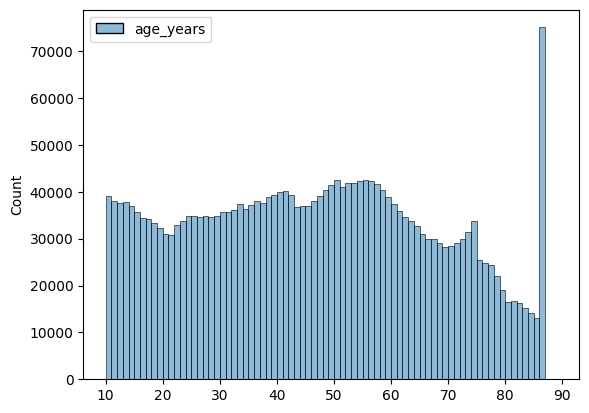

In [18]:
# Plot Age
sns.histplot(
    spc.people.unnest("demographics").select("age_years").to_pandas(),
    bins=np.arange(10, 90),
)

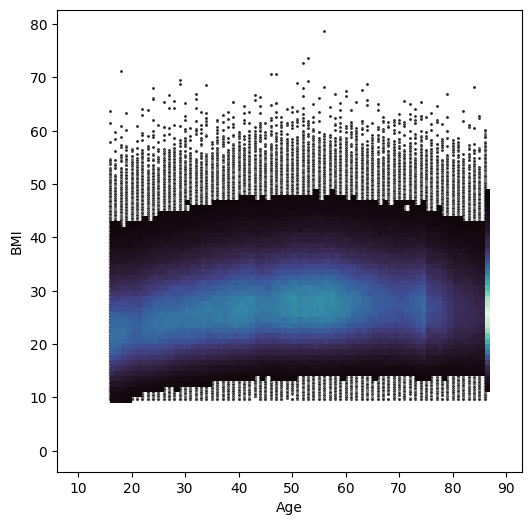

In [19]:
# Plot 2D hist of Age and BMI
age_bmi = (
    spc.people.unnest("demographics")
    .unnest("health")
    .select(["age_years", "bmi"])
    .filter(pl.col("bmi") != None)
    .to_numpy()
)

# Draw a combination of histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
x, y = age_bmi[:, 0], age_bmi[:, 1]
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(
    x=x, y=y, bins=[np.arange(10, 90), np.arange(0, 60)], pthresh=0.01, cmap="mako"
)
plt.gca().set(xlabel="Age", ylabel="BMI")
plt.show()

#### 2.2 Combine with weekday diaries

**Question: Are weekday activities related to health features?**

Pick some features to explore, merge and aggregate. See [data schema](https://github.com/alan-turing-institute/uatk-spc/blob/main/synthpop.proto) for more details.


In [20]:
# Merge and pick first diary entry as an example, many possible options for aggregating!
features = {
    # "health": ["bmi"],
    "health": [
        "bmi",
        "has_cardiovascular_disease",
        "has_diabetes",
        "has_high_blood_pressure",
        "self_assessed_health",
        "life_satisfaction",
    ],
    "demographics": ["age_years", "sex", "nssec8"],
    "employment": ["pwkstat", "salary_yearly"],
}
merged = spc.merge_people_and_time_use_diaries(features, "weekday_diaries")

# Pick a subset of activities to explore
activities = ["pmwalk", "pmcycle", "pmprivate", "pmpublic", "pmunknown", "pleisure"]

# First diary per person across all diaries
merged_agg = (
    merged.select(
        ["id"]
        + activities
        + features["health"]
        + features["demographics"]
        + features["employment"]
    ).groupby(["id"], maintain_order=True)
    .first()
)

In [21]:
merged_agg.head()

id,pmwalk,pmcycle,pmprivate,pmpublic,pmunknown,pleisure,bmi,has_cardiovascular_disease,has_diabetes,has_high_blood_pressure,self_assessed_health,life_satisfaction,age_years,sex,nssec8,pwkstat,salary_yearly
u64,f32,f32,f32,f32,f32,f32,f32,bool,bool,bool,i32,i32,u32,i32,i32,i32,f32
0,0.76923,0.0,0.76923,0.0,0.23077,0.04861,37.280968,false,false,false,1,3,40,2,6,7,null
1,0.26667,0.0,0.26667,0.73333,0.0,0.07639,35.771095,false,false,false,2,3,39,1,1,1,127906.320312
2,0.0,0.0,0.83333,0.0,0.16667,0.00694,null,false,false,false,1,null,7,2,null,0,null
3,0.0,0.0,0.9,0.0,0.1,0.05556,34.354729,true,true,true,4,3,66,1,4,6,null
4,0.6,0.0,1.0,0.0,0.0,0.08333,20.597435,false,false,false,3,null,60,2,1,1,64961.53125


#### Plotting activity distributions


In [22]:
print(activities)

['pmwalk', 'pmcycle', 'pmprivate', 'pmpublic', 'pmunknown', 'pleisure']


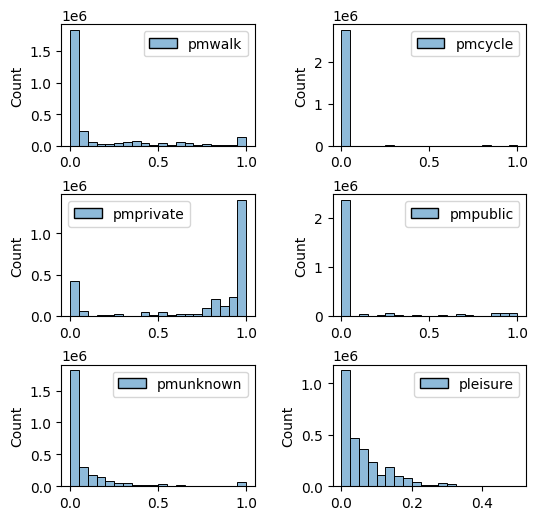

In [23]:
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols)
fig.set_size_inches(6, 6)
for idx, activity in enumerate(activities):
    row, col = idx // ncols, idx % ncols
    ax = axs[row, col]
    sns.histplot(merged_agg.select(activity).to_pandas(), bins=20, ax=ax)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

Perform a simple clustering of the six activity features with K-means.


In [24]:
nclusters = 6
data = merged_agg.select(activities).to_numpy()
labels = KMeans(nclusters, random_state=0).fit_predict(data)

Plot the resultant means per feature of the clusters.


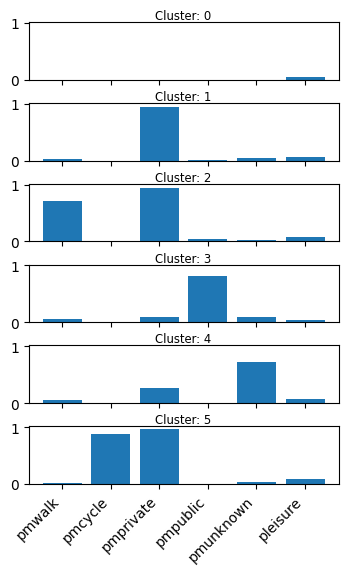

In [25]:
nrows, ncols = nclusters, 1
fig, axs = plt.subplots(nrows, ncols, squeeze=False, sharey=True)
fig.set_size_inches(4, 6)
for cluster_idx in np.arange(0, nclusters):
    ax = axs[cluster_idx, 0]
    idxs = np.where(cluster_idx == labels)[0]
    ax.set_title(
        f"Cluster: {cluster_idx}", fontdict={"size": "small"}, ha="center", pad=-0.1
    )
    ax.bar(
        np.arange(len(activities)),
        merged_agg.select(activities).to_pandas().iloc[idxs, :].mean(axis=0).to_numpy(),
    )
    ax.set_xticks(np.arange(len(activities)))
    if cluster_idx == nclusters - 1:
        ax.set_xticklabels(activities, rotation=45, ha="right")
    else:
        ax.set_xticklabels([])
plt.subplots_adjust(hspace=0.4)
plt.show()

Plot the distribution of age and bmi for each cluster.


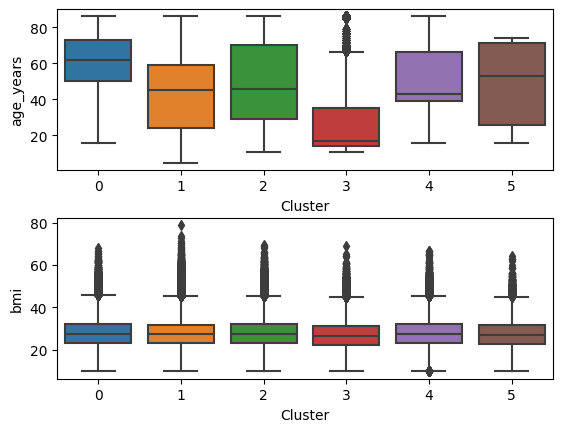

In [26]:
fig, axs = plt.subplots(2, 1, squeeze=False)
for idx, y in enumerate(["age_years", "bmi"]):
    ax = axs[idx, 0]
    sns.boxplot(
        merged_agg.with_columns(
            Cluster=pl.lit(labels),
        ).to_pandas(),
        x="Cluster",
        y=y,
        ax=ax,
    )
# fig.set_size_inches(5, 6)
fig.subplots_adjust(hspace=0.3)
plt.show()

Plot the break down for age with additionally life satisfaction included.


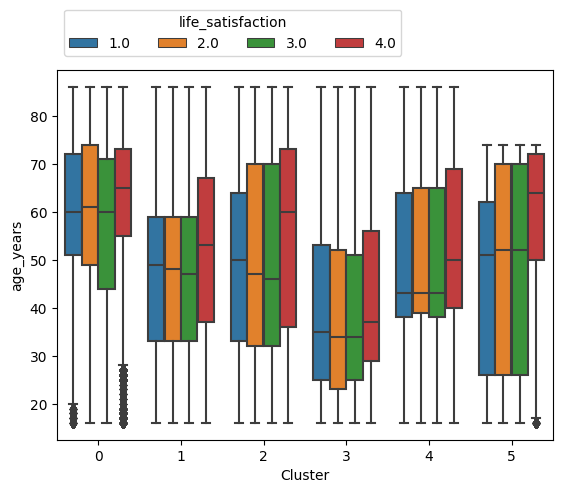

In [27]:
ax = sns.boxplot(
    merged_agg.with_columns(
        Cluster=pl.lit(labels),
    ).to_pandas(),
    x="Cluster",
    y="age_years",
    hue="life_satisfaction",
    # legend_loc="upper right"
    # hue="has_high_blood_pressure"
)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1.02), ncols=5)

### 3. Comparison of two regions

Multiple readers can be created to allow comparison of different region's populations.


In [28]:
greater_london = SPCReader(
    "../../data/output/England/2020",
    "greater-london",
)
northwest_transpennine = SPCReader(
    "../../data/output/special/2020", "northwest_transpennine"
)

In [29]:
def combine(left: pl.DataFrame, right: pl.DataFrame, label_left: str, label_right: str):
    """Construct combined table with people and households and two regions"""
    combined = pl.concat(
        [
            left.with_columns(region=pl.lit(label_left)),
            right.with_columns(region=pl.lit(label_right)),
        ]
    )
    return (
        combined.unnest("demographics")
        .unnest("health")
        .select(pl.all().exclude("nssec8"))
        .unnest("details")
        .unnest("employment")
    )

Make combined dataframe


In [30]:
left_region, right_region = "Greater London", "Northwest Transpennine"
combined = combine(
    greater_london.merge_people_and_households(),
    northwest_transpennine.merge_people_and_households(),
    left_region,
    right_region,
)

In [31]:
print(f"Combined regions has a population of {combined.shape[0]:,.0f} people")

Combined regions has a population of 15,608,611 people


Examine columns


In [32]:
dict(zip(combined.columns, combined.dtypes))

{'id': UInt64,
 'household': UInt64,
 'workplace': UInt64,
 'location': Struct([Field('x', Float32), Field('y', Float32)]),
 'orig_pid': Utf8,
 'id_tus_hh': Int64,
 'id_tus_p': Int64,
 'pid_hs': Int64,
 'sex': Int32,
 'age_years': UInt32,
 'ethnicity': Int32,
 'sic1d2007': Utf8,
 'sic2d2007': UInt64,
 'soc2010': UInt64,
 'pwkstat': Int32,
 'salary_yearly': Float32,
 'salary_hourly': Float32,
 'bmi': Float32,
 'has_cardiovascular_disease': Boolean,
 'has_diabetes': Boolean,
 'has_high_blood_pressure': Boolean,
 'number_medications': UInt64,
 'self_assessed_health': Int32,
 'life_satisfaction': Int32,
 'events': Struct([Field('sport', Float32), Field('rugby', Float32), Field('concert_m', Float32), Field('concert_f', Float32), Field('concert_ms', Float32), Field('concert_fs', Float32), Field('museum', Float32)]),
 'weekday_diaries': List(UInt64),
 'weekend_diaries': List(UInt64),
 'msoa': Utf8,
 'oa': Utf8,
 'members': List(UInt64),
 'hid': Utf8,
 'nssec8': Int32,
 'accommodation_type': I

**Question: how do salaries in the two regions compare? What features are associated?**


Histogram of yearly salaries for two regions


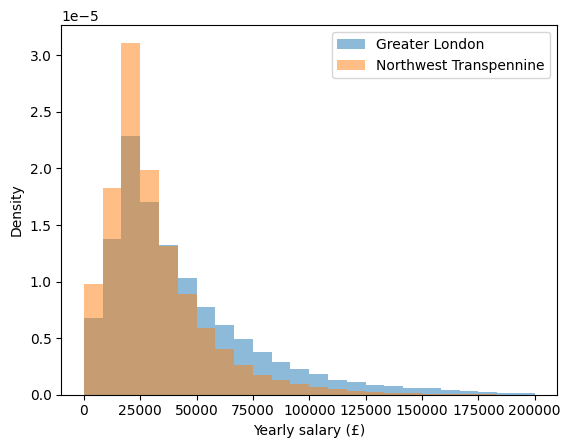

In [33]:
fig, ax = plt.subplots(1, 1)
bins = np.linspace(0, 200000, 25, endpoint=True)
ax.hist(
    combined.filter(pl.col("region") == left_region).select("salary_yearly"),
    alpha=0.5,
    bins=bins,
    label=left_region,
    density=True,
)
ax.hist(
    combined.filter(pl.col("region") == right_region).select("salary_yearly"),
    alpha=0.5,
    bins=bins,
    label=right_region,
    density=True,
)
ax.legend()
# ax.set(ylim=(0, 0.0001))
ax.set(xlabel="Yearly salary (£)", ylabel="Density")
plt.show()

A boxplot split by region and tenure of log scaled yearly salary.


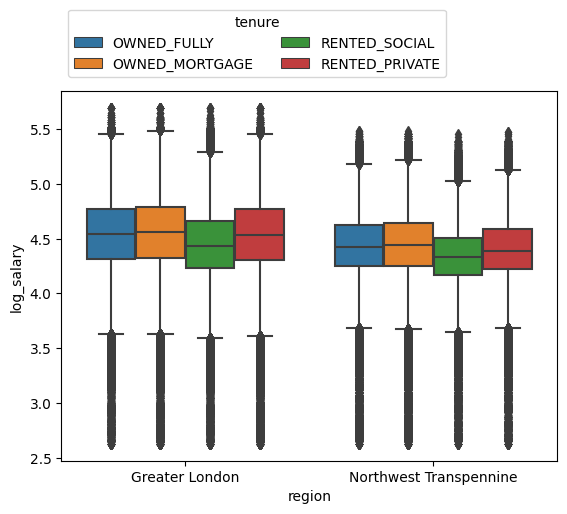

In [34]:
ax = sns.boxplot(
    combined.with_columns(
        log_salary=np.log10(pl.col("salary_yearly")),
        tenure=pl.col("tenure").apply(
            lambda x: {
                1: "OWNED_FULLY",
                2: "OWNED_MORTGAGE",
                4: "RENTED_SOCIAL",
                5: "RENTED_PRIVATE",
            }[x]
        ),
    ).to_pandas(),
    y="log_salary",
    x="region",
    hue="tenure",
)
sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 1.02), ncols=2)